### Ensemble Classification

Goal: Beat logistic regression with machine learning

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
import sklearn.metrics as sk
from sklearn.grid_search import GridSearchCV

import pandas as pd
from collections import Counter
import numpy as np
import nltk

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in and vectorize 

modern = pd.read_pickle('data/cards_modern_no_name.pkl')

modern['bincolor'] = pd.Categorical.from_array(modern.colors).codes

y = modern.bincolor

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(modern.text)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                             random_state=42)

print "There are {:,} words in the vocabulary.".format(len(vectorizer.vocabulary_))

There are 1,229 words in the vocabulary.


In [3]:
# Extreme Trees 

from sklearn.ensemble import ExtraTreesClassifier

rf = ExtraTreesClassifier(n_estimators=100, min_samples_leaf=2, n_jobs=-1)
rf.fit(X_train, y_train)

mses = cross_val_score(rf, X_train, y_train,
                       cv=3, scoring='mean_squared_error') * -1

acc = cross_val_score(rf, X_train, y_train,
                       cv=3, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 1.639, Accuracy: 0.677


#### Not as good as logistic regression.

#### Grid searching may optimize parameters a bit. 

In [35]:
# Grid search extreme trees

param_grid = { 
    'n_estimators': [80, 100, 200, 500],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [None, 8, 10],
    'bootstrap': [True, False],
    'max_features': ['log2', None]}

CV_rf = GridSearchCV(estimator=rf, 
                     param_grid=param_grid, 
                     cv= 3,
                     verbose=True,
                     scoring='mean_squared_error')

print "Best parameters:", CV_rf.best_params_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:  4.3min
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed: 12.5min
[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 31.1min finished


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters: {u'max_features': None, u'n_estimators': 500, u'bootstrap': True, u'max_depth': None, u'min_samples_leaf': 2}


In [4]:
CV_rf = ExtraTreesClassifier(n_estimators=500, 
                             max_features=None, 
                             min_samples_leaf=2, 
                             bootstrap=True, 
                             n_jobs=-1)

CV_rf.fit(X_train, y_train)

mses = cross_val_score(rf, X_train, y_train,
                       cv=3, scoring='mean_squared_error') * -1

acc = cross_val_score(rf, X_train, y_train,
                       cv=3, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 1.653, Accuracy: 0.678


#### .1% improvement after extensive parameter search

In [5]:
# feature ranking 

importances = CV_rf.feature_importances_

indices = np.argsort(importances)[::-1]

indices[:9]

array([ 249,  487, 1054,  233,  626,  282,  412, 1079,  638], dtype=int64)

In [6]:
print("Feature ranking:")
print 

for i in xrange(20):
    for key, value in vectorizer.vocabulary_.items():
        if value == indices[i]:
            print("%d. %s (%f)" % (i + 1, key, importances[indices[i]]))

Feature ranking:

1. deals (0.034390)
2. haste (0.025727)
3. target (0.021227)
4. creature (0.020228)
5. life (0.020083)
6. discards (0.019211)
7. flying (0.018975)
8. this (0.016125)
9. loses (0.015160)
10. draw (0.014979)
11. green (0.014480)
12. black (0.013279)
13. white (0.013271)
14. destroy (0.012911)
15. trample (0.012883)
16. vigilance (0.012711)
17. you (0.011902)
18. damage (0.011867)
19. gets (0.011085)
20. turn (0.010482)


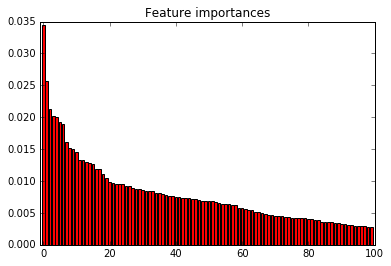

In [8]:
num_feat = 100 

plt.figure()
plt.title("Feature importances")
plt.bar(range(num_feat), importances[indices[:num_feat]],
       color="r", align="center")
plt.xlim([-1, num_feat])
plt.show()

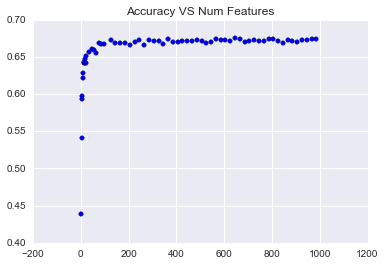

In [107]:
n, acc = 1, [[],[]]
while n <= 1000:
    et = ExtraTreesClassifier(n_estimators=n, 
                              min_samples_leaf=2, 
                              bootstrap=True,
                              n_jobs=-1)
    
    xacc = cross_val_score(et, X_train, y_train,
                          cv=3, scoring='accuracy') 
    acc[0] += [n]
    acc[1] += [xacc.mean()]
    
    if n < 25:
        n += 2
    if n < 100 and n >= 25:
        n += 10
    if n >= 100:
        n += 20
    
plt.figure()
plt.title("Accuracy VS Num Features")
plt.scatter(acc[0], acc[1])
plt.show();

In [7]:
from sklearn.ensemble import GradientBoostingClassifier

gd = GradientBoostingClassifier(n_estimators = 40,
                                learning_rate = 0.5,
                                min_samples_leaf = 1,
                                random_state=42)

mses = cross_val_score(gd, X_train.toarray(), y_train,
                       cv=3, scoring='mean_squared_error') * -1

acc = cross_val_score(gd, X_train.toarray(), y_train,
                       cv=3, scoring='accuracy') 

print "MSE: %s, Accuracy: %s" % (mses.mean().round(3), acc.mean().round(3))

MSE: 1.696, Accuracy: 0.672


In [118]:
# Gradient Descent Boost grid search 

from sklearn.ensemble import GradientBoostingClassifier

gd_boost_grid = {'learning_rate': [.1, .5],
            'n_estimators': [100, 200],
              'min_samples_leaf': [1, 2]}

gd_gridsearch = GridSearchCV(GradientBoostingClassifier(random_state=42),
                             param_grid=gd_boost_grid,
                             verbose=True,
                             cv= 3,
                             scoring='mean_squared_error')

gd_gridsearch.fit(X_train.toarray(), y_train)

print "GD boost best parameters:", gd_gridsearch.best_params_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:  1.4min
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.5min finished


Fitting 3 folds for each of 2 candidates, totalling 6 fits
 GD boost best parameters: {u'n_estimators': 80, u'learning_rate': 0.5, u'min_samples_leaf': 1}


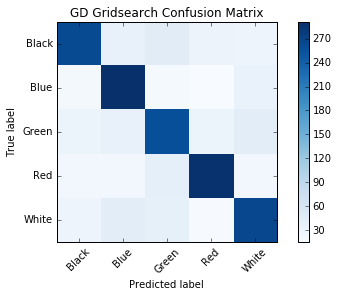

In [11]:
# Gradient Boost confusion matrix 

gd_gridsearch = GradientBoostingClassifier(n_estimators = 80,
                                            learning_rate = 0.5,
                                            min_samples_leaf = 1,
                                            random_state=42)

gd_gridsearch.fit(X_train.toarray(), y_train)


cm2 = sk.confusion_matrix(y_test, gd_gridsearch.predict(X_test.toarray()))

label = ["Black", "Blue", "Green", "Red", "White"]

def plot_confusion_matrix(cm, title='Logistic Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(label))
    plt.xticks(tick_marks, label, rotation=45)
    plt.yticks(tick_marks, label)    
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm2, title="GD Gridsearch Confusion Matrix");

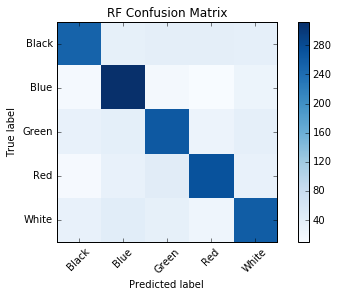

In [14]:
# Extra Trees confusion matrix 

cm = sk.confusion_matrix(y_test, CV_rf.predict(X_test))

plot_confusion_matrix(cm, title="RF Confusion Matrix");  

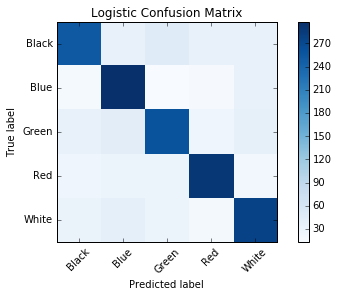

In [12]:
# logistic confusion matrix 

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=2)

clf.fit(X_train, y_train)

cm3 = sk.confusion_matrix(y_test, clf.predict(X_test), labels=None)

plot_confusion_matrix(cm3, title="Logistic Confusion Matrix");  

In [14]:
from sklearn.metrics import roc_curve

def get_scores(model, **kwargs):
    model.fit(X_train.toarray(), y_train)
    y_prods = model.predict_proba(X_test.toarray())
    y_prod = [b[i] for i, b in zip(y_test, y_prods)]
    y_pred = model.predict(X_test.toarray()) 
    y_true = [1 if a==b else 0 for a,b in zip(y_test, y_pred)]
    recall, precision, thresh = roc_curve(y_true, y_prod)
    plt.clf()
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show();

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


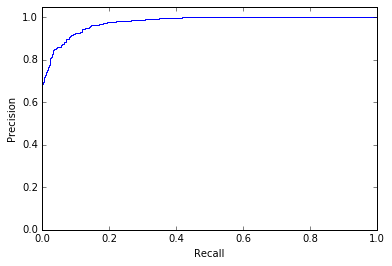


ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


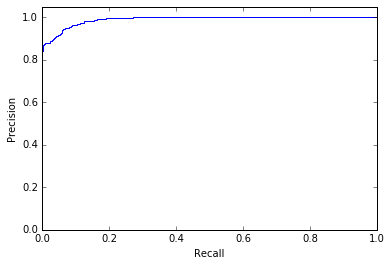


GradientBoostingClassifier(init=None, learning_rate=0.5, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)


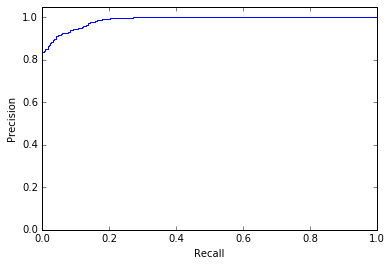


GradientBoostingClassifier(init=None, learning_rate=0.5, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)


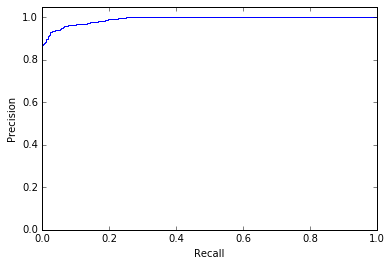


LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class=u'ovr', n_jobs=1,
          penalty='l2', random_state=None, solver=u'lbfgs', tol=0.0001,
          verbose=0, warm_start=False)


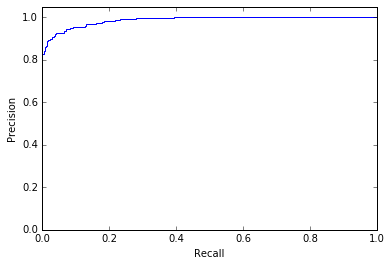

In [66]:
classifiers = [rf, CV_rf, gd, gd_gridsearch, clf]

for c in classifiers:
    print c
    get_scores(c)
    print 

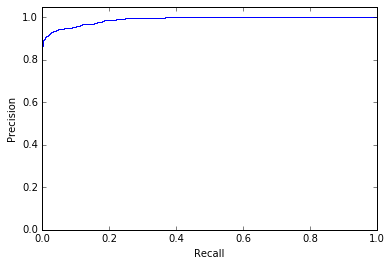

In [75]:
y_prods = clf.predict_proba(X_test.toarray())
y_prod = [b[i] for i, b in zip(y_test, y_prods)]
y_pred = clf.predict(X_test.toarray()) 
y_true = [1 if a==b else 0 for a,b in zip(y_test, y_pred)]
recall, precision, thresh = roc_curve(y_true, y_prod)
plt.clf()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show();

In [82]:
y_prods[0]

array([ 0.03582697,  0.78368691,  0.03430356,  0.02859727,  0.1175853 ])